In [44]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd

# Custom Transformer to extract network features
class NetworkFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, G):
    features = []
    betweenness = nx.betweenness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)
    for node in G.nodes():
        node_features = [
            G.degree(node),
            nx.clustering(G, node),
            betweenness[node],
            eigenvector[node]
        ]
        features.append(node_features)
    return np.array(features)


# Function to train deep learning model for feature extraction
def train_deep_learning_model(X_train, y_train, param_grid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = Sequential()
    model.add(LSTM(units=param_grid['units'], input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=param_grid['optimizer'], loss='mean_squared_error')

    
    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    model.fit(X_train_reshaped, y_train, epochs=param_grid['epochs'], batch_size=param_grid['batch_size'])
    
    return model, scaler

# Function to calculate Ricci curvature at each node
def calculate_ricci_curvature(G, a, x):
    ricci_curvature = {}
    for edge in G.edges():
        i, j = edge
        if i > j:  # Ensure consistent key format
            i, j = j, i
        ricci_curvature[edge] = calculate_edge_ricci_curvature(G, a, x, i, j)
    return ricci_curvature

# Function to calculate Ricci curvature for a single edge
def calculate_edge_ricci_curvature(G, a, x, i, j):
    deg_i = G.degree(i)
    deg_j = G.degree(j)
    curvature_sum = 0
    for k in G.nodes():
        if k != j:
            curvature_sum += a[i][k] * x[i] * x[k]
    for k in G.nodes():
        if k != i:
            curvature_sum += a[k][j] * x[k] * x[j]
    if deg_i * ((1 + deg_j * (x[i] * x[j]) ** 0.5) ** -0.5 * curvature_sum) ** 0.5 != 0:
        ricci_curvature = deg_i * ((1 + deg_j * (x[i] * x[j]) ** 0.5) ** -0.5 * curvature_sum) ** 0.5
    else:
        ricci_curvature = 0
    # Ensure consistent edge key ordering
    if i > j:
        return ricci_curvature, (j, i)
    else:
        return ricci_curvature, (i, j)

# Function to update distances based on Ricci flow
def update_distances(G, d, ricci_curvature, delta_t):
    new_d = {}
    for edge in G.edges():
        i, j = edge
        # Check if key exists in the expected order
        if edge in ricci_curvature:
            ricci_curvature_diff = float(ricci_curvature[edge][0])  # Extract curvature value before conversion
        else:
            # If not, check for reversed order and use that value (with conversion)
            ricci_curvature_diff = float(ricci_curvature[(j, i)][0]) if (j, i) in ricci_curvature else 0
        new_d[edge] = d[edge] + delta_t * (ricci_curvature_diff - float(ricci_curvature[edge][0])) * d[edge]
    return new_d

# Function to perform discrete Ricci flow iterations
def discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations, convergence_threshold=1e-6):
    d_stem = calculate_distances(G, a, x_stem)
    d_diff = calculate_distances(G, a, x_diff)
    ricci_curvature_stem = calculate_ricci_curvature(G, a, x_stem)
    ricci_curvature_diff = calculate_ricci_curvature(G, a, x_diff)
    prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    for _ in range(num_iterations):
        d_stem = update_distances(G, d_stem, ricci_curvature_stem, delta_t)
        d_diff = update_distances(G, d_diff, ricci_curvature_diff, delta_t)
        if np.allclose(list(d_stem.values()), list(prev_d_stem.values()), atol=convergence_threshold) and \
           np.allclose(list(d_diff.values()), list(prev_d_diff.values()), atol=convergence_threshold):
            break
        prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    return d_stem, d_diff



# Function to calculate distances based on edge weights
def calculate_distances(G, a, x):
    distances = {}
    for edge in G.edges():
        i, j = edge
        distances[edge] = a[i][j] * x[i] * x[j]
    return distances

# Function to calculate proliferation index based on network features and distances
def calculate_pi(G, d, deep_learning_features, model, scaler):
    pi_scores = []
    for node in G.nodes():
        node_features = [
            G.degree(node),
            nx.clustering(G, node),
            d.get((node,), 0)
        ]
        deep_learning_feature = deep_learning_features[node]
        combined_features = np.concatenate((node_features, deep_learning_feature[:3]))
        combined_features_scaled = scaler.transform(combined_features.reshape(1, -1))
        pi_score = model.predict(combined_features_scaled)
        pi_scores.append(pi_score[0][0])
    return pi_scores



# Load protein interaction network data
int_red = np.zeros((15, 15), dtype=int)

# Fill in the adjacency matrix with some example values
for i in range(15):
    for j in range(15):
        if i != j:
            int_red[i, j] = np.random.randint(0, 2)
            
# Create an empty graph
G = nx.Graph()

# Add edges to the graph based on the adjacency matrix
for i in range(len(int_red)):
    for j in range(len(int_red)):
        if i != j and int_red[i, j] == 1:
            G.add_edge(i, j)

gene_symbols = ['ATGCAA', 'ATGCAB', 'ATGCAC', 'ATGCAD', 'ATGCAE', 'ATGCAF', 'ATGCAG', 'ATGCAH', 'ATGCAI', 'ATGCAJ', 'ATGCAK', 'ATGCAL', 'ATGCAM', 'ATGCAN', 'ATGCAO']

# Generate random gene expression data with corresponding gene symbols
gene_expression_data = {gene_symbol: np.random.rand(4) for gene_symbol in gene_symbols}  # 4 samples for each gene

# Placeholder protein data
protein_data = {gene_symbol: np.random.rand() for gene_symbol in gene_symbols}

# Display gene expression data and protein data
print("Gene Expression Data:")
for gene_symbol, expression_levels in gene_expression_data.items():
    print(f"{gene_symbol}: {expression_levels}")
print("\nProtein Data:")
print(protein_data)
print("Shape of X_network:", X_network.shape)


# Determine the number of samples in the gene expression data
num_samples_gene_expression = len(next(iter(gene_expression_data.values())))

# Extract gene expression values as a list
gene_expression_values = list(gene_expression_data.values())

# Ensure gene expression data and protein data have the same number of samples
num_samples = min(len(gene_expression_values), len(protein_data))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression_values[:num_samples], list(protein_data.values())[:num_samples], test_size=0.2, random_state=42)

# Define hyperparameters for the deep learning model
param_grid = {
    'units': 50,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}

# Train deep learning model for feature extraction
model, scaler = train_deep_learning_model(np.array(X_train), np.array(y_train), param_grid)

# Extract network features
network_feature_extractor = NetworkFeatureExtractor()
X_network = network_feature_extractor.transform(G)

# Placeholder for edge weights based on gene expression data
# Replace this with actual edge weights based on gene expression data or other network-based weight calculations
a = np.random.rand(len(G.nodes()), len(G.nodes()))

# Define initial and final states for the Ricci flow
# You can replace these placeholders with actual initial and final states based on biological knowledge
x_stem = np.random.rand(len(G.nodes()))  # Placeholder for undifferentiated cell state
x_diff = np.random.rand(len(G.nodes()))  # Placeholder for fully differentiated cell state

# Perform discrete Ricci flow iterations
delta_t = 0.1  # Placeholder for time step
num_iterations = 10  # Placeholder for number of iterations
d_stem, d_diff = discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations)

# Calculate proliferation index
# Assuming pi_scores_stem is a list of scores and nodes_indices is a list of corresponding node indices
pi_scores_stem = {node_index: score for node_index, score in enumerate(pi_scores_stem)}

pi_scores_diff = calculate_pi(G, d_diff, X_network, model, scaler)

# Evaluate model performance on the testing set
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1]))
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display results in a table
print("Node\tCell\tGene\tProliferation Index (Stem)\tProliferation Index (Diff)")
for idx, node in enumerate(G.nodes(), start=1):
    gene = gene_symbols[idx - 1]  # Generate gene name based on gene symbols
    print(f"{node}\tCell_{node}\t{gene}\t{pi_scores_stem[node]}\t{pi_scores_diff[node]}")

# Categorize cells into groups based on proliferation index
threshold1 = 0.5
threshold2 = 0.3
threshold3 = 0.1

group1 = {node: score for node, score in pi_scores_stem.items() if score > threshold1}
group2 = {node: score for node, score in pi_scores_stem.items() if threshold2 < score <= threshold1}
group3 = {node: score for node, score in pi_scores_stem.items() if threshold3 < score <= threshold2}
group4 = {node: score for node, score in pi_scores_stem.items() if score <= threshold3}

# Print cell groups
print("\nCell Groups:")
print("Group 1 (Carcinogenic Persister Cell):", group1)
print("Group 2 (Probably Carcinogenic Persister Cell):", group2)
print("Group 3 (Possibly Carcinogenic Persister Cell):", group3)
print("Group 4 (Non-Carcinogenic Persister Cell):", group4)


# Visualization: Network structure
plt.figure(figsize=(10, 8))

# Draw the network
pos = nx.spring_layout(G)  # Compute layout for nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)

# Add labels for each node with its index and gene symbol
labels = {node: f"Cell_{node}\n{gene_symbols[node]}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=8)

plt.title('Protein Interaction Network')
plt.show()

# Visualization: Scatter plot of PI scores vs. true scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True PI Score')
plt.ylabel('Predicted PI Score')
plt.title('True vs. Predicted PI Scores')
plt.legend()
plt.grid(True)
plt.show()


IndentationError: expected an indented block after function definition on line 19 (1500299187.py, line 20)

Gene Expression Data:
ATGCAA: [0.36001744 0.50172932 0.65269447 0.13621205]
ATGCAB: [0.34369751 0.41890426 0.39321816 0.130123  ]
ATGCAC: [0.00126475 0.86243238 0.10236196 0.67920749]
ATGCAD: [0.64008215 0.59404706 0.08754796 0.12416789]
ATGCAE: [0.38878804 0.24463072 0.44632417 0.93996591]
ATGCAF: [0.36027889 0.63040012 0.81355756 0.89872266]
ATGCAG: [0.43272116 0.97641624 0.80064743 0.9769206 ]
ATGCAH: [0.51804857 0.91991741 0.35602271 0.49590665]
ATGCAI: [0.19896882 0.65542149 0.8110732  0.21420477]
ATGCAJ: [0.8411793  0.12664032 0.03295052 0.27719782]
ATGCAK: [0.54351234 0.05815564 0.11932463 0.44641818]
ATGCAL: [0.0727364  0.92947771 0.81008635 0.94858087]
ATGCAM: [0.58405826 0.54910329 0.62830199 0.56185623]
ATGCAN: [0.42081596 0.38530569 0.628846   0.65691875]
ATGCAO: [0.71212534 0.41790074 0.21895164 0.3966117 ]

Protein Data:
{'ATGCAA': 0.4047803858717893, 'ATGCAB': 0.4802478434912617, 'ATGCAC': 0.4117602273375378, 'ATGCAD': 0.6774973095659268, 'ATGCAE': 0.7748681493343619, 'A

/users/barmanjy/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3543
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3451
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3361
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3272
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3182
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.3093
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3004
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2914
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2824
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━

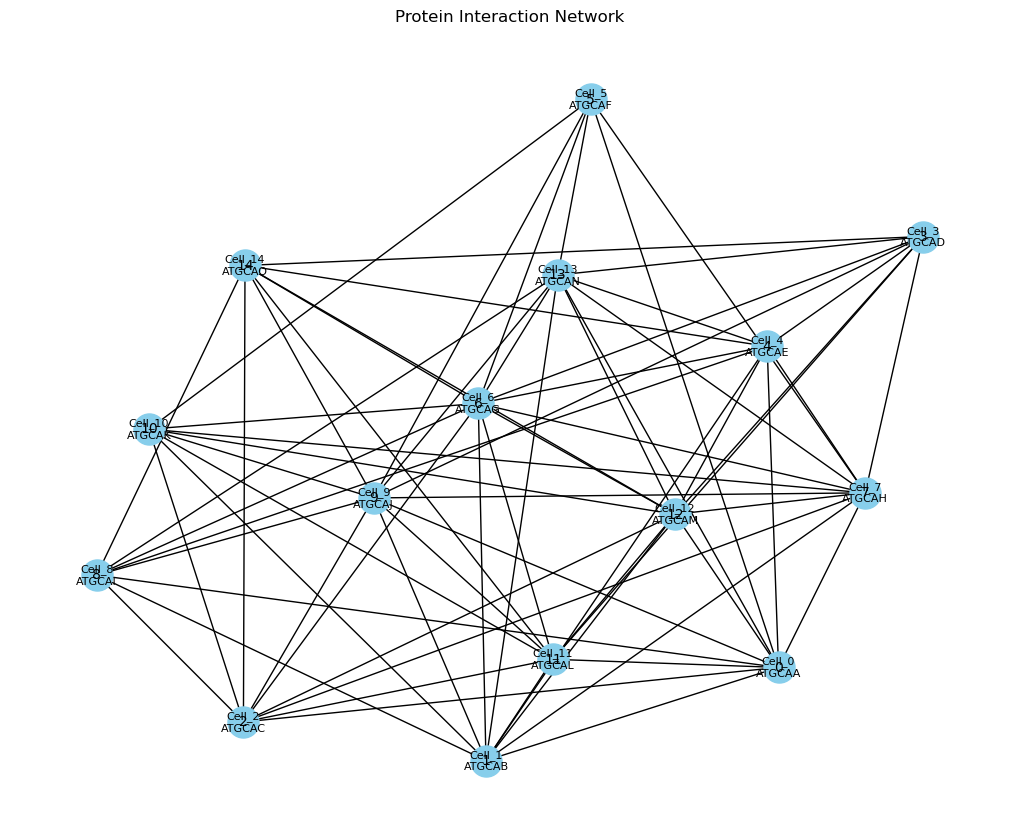

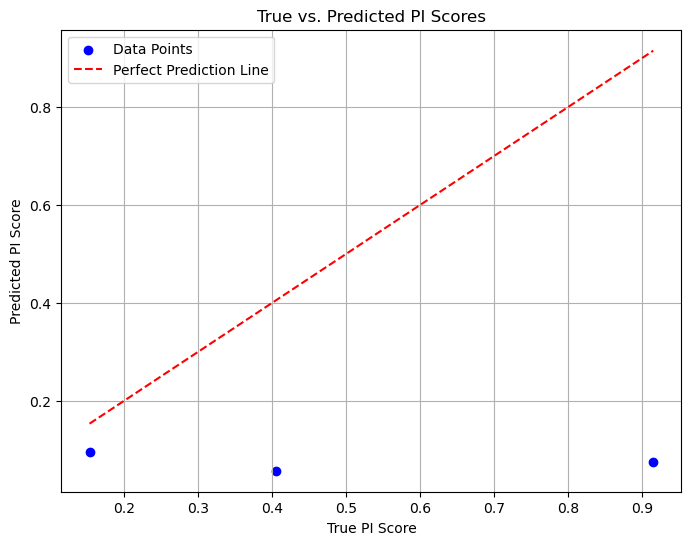

In [38]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd

# Custom Transformer to extract network features
class NetworkFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, G):
        features = []
        for node in G.nodes():
            node_features = [
                G.degree(node),
                nx.clustering(G, node),
                nx.betweenness_centrality(G)[node],
                nx.eigenvector_centrality(G)[node]
            ]
            features.append(node_features)
        return np.array(features)

# Function to train deep learning model for feature extraction
def train_deep_learning_model(X_train, y_train, param_grid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = Sequential()
    model.add(LSTM(units=param_grid['units'], input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=param_grid['optimizer'], loss='mean_squared_error')

    
    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    model.fit(X_train_reshaped, y_train, epochs=param_grid['epochs'], batch_size=param_grid['batch_size'])
    
    return model, scaler

# Function to calculate distances based on edge weights
def calculate_distances(G, a, x):
    distances = {}
    for edge in G.edges():
        i, j = edge
        distances[edge] = a[i][j] * x[i] * x[j]
    return distances

# Function to perform discrete Ricci flow iterations
def discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations, convergence_threshold=1e-6):
    d_stem = calculate_distances(G, a, x_stem)
    d_diff = calculate_distances(G, a, x_diff)
    ricci_curvature_stem = calculate_ricci_curvature(G, a, x_stem)
    ricci_curvature_diff = calculate_ricci_curvature(G, a, x_diff)
    prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    for _ in range(num_iterations):
        d_stem = update_distances(G, d_stem, ricci_curvature_stem, delta_t)
        d_diff = update_distances(G, d_diff, ricci_curvature_diff, delta_t)
        # Convergence check
        if np.allclose(np.array(list(d_stem.values())), np.array(list(prev_d_stem.values())), atol=convergence_threshold) and \
           np.allclose(np.array(list(d_diff.values())), np.array(list(prev_d_diff.values())), atol=convergence_threshold):
            break
        prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    return d_stem, d_diff

# Load protein interaction network data
int_red = np.zeros((15, 15), dtype=int)

# Fill in the adjacency matrix with some example values
for i in range(15):
    for j in range(15):
        if i != j:
            int_red[i, j] = np.random.randint(0, 2)
            
# Create an empty graph
G = nx.Graph()

# Add edges to the graph based on the adjacency matrix
for i in range(len(int_red)):
    for j in range(len(int_red)):
        if i != j and int_red[i, j] == 1:
            G.add_edge(i, j)

gene_symbols = ['ATGCAA', 'ATGCAB', 'ATGCAC', 'ATGCAD', 'ATGCAE', 'ATGCAF', 'ATGCAG', 'ATGCAH', 'ATGCAI', 'ATGCAJ', 'ATGCAK', 'ATGCAL', 'ATGCAM', 'ATGCAN', 'ATGCAO']

# Generate random gene expression data with corresponding gene symbols
gene_expression_data = {gene_symbol: np.random.rand(4) for gene_symbol in gene_symbols}  # 4 samples for each gene

# Placeholder protein data
protein_data = {gene_symbol: np.random.rand() for gene_symbol in gene_symbols}

# Display gene expression data and protein data
print("Gene Expression Data:")
for gene_symbol, expression_levels in gene_expression_data.items():
    print(f"{gene_symbol}: {expression_levels}")
print("\nProtein Data:")
print(protein_data)

# Determine the number of samples in the gene expression data
num_samples_gene_expression = len(next(iter(gene_expression_data.values())))

# Extract gene expression values as a list
gene_expression_values = list(gene_expression_data.values())

# Ensure gene expression data and protein data have the same number of samples
num_samples = min(len(gene_expression_values), len(protein_data))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression_values[:num_samples], list(protein_data.values())[:num_samples], test_size=0.2, random_state=42)

# Define hyperparameters for the deep learning model
param_grid = {
    'units': 50,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}

# Train deep learning model for feature extraction
model, scaler = train_deep_learning_model(np.array(X_train), np.array(y_train), param_grid)

# Extract network features
network_feature_extractor = NetworkFeatureExtractor()
X_network = network_feature_extractor.transform(G)

# Placeholder for edge weights based on gene expression data
# Replace this with actual edge weights based on gene expression data or other network-based weight calculations
a = np.random.rand(len(G.nodes()), len(G.nodes()))

# Define initial and final states for the Ricci flow
# You can replace these placeholders with actual initial and final states based on biological knowledge
x_stem = np.random.rand(len(G.nodes()))  # Placeholder for undifferentiated cell state
x_diff = np.random.rand(len(G.nodes()))  # Placeholder for fully differentiated cell state

# Perform discrete Ricci flow iterations
delta_t = 0.1  # Placeholder for time step
num_iterations = 10  # Placeholder for number of iterations
d_stem, d_diff = discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations)

# Calculate proliferation index
pi_scores_stem = calculate_pi(G, d_stem, X_network, model, scaler)
pi_scores_diff = calculate_pi(G, d_diff, X_network, model, scaler)

# Convert pi_scores_stem and pi_scores_diff to dictionaries for easier manipulation
pi_scores_stem = {node: score for node, score in enumerate(pi_scores_stem)}
pi_scores_diff = {node: score for node, score in enumerate(pi_scores_diff)}

# Categorize cells into groups based on proliferation index
threshold1 = 0.5
threshold2 = 0.3
threshold3 = 0.1

group1 = {node: score for node, score in pi_scores_stem.items() if score > threshold1}
group2 = {node: score for node, score in pi_scores_stem.items() if threshold2 < score <= threshold1}
group3 = {node: score for node, score in pi_scores_stem.items() if threshold3 < score <= threshold2}
group4 = {node: score for node, score in pi_scores_stem.items() if score <= threshold3}


# Print cell groups
print("\nCell Groups:")
print("Group 1 (Carcinogenic Persister Cell):", group1)
print("Group 2 (Probably Carcinogenic Persister Cell):", group2)
print("Group 3 (Possibly Carcinogenic Persister Cell):", group3)
print("Group 4 (Non-Carcinogenic Persister Cell):", group4)

#Model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Print model evaluation metrics
print("\nModel Evaluation Metrics:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

# Visualization: Network structure
plt.figure(figsize=(10, 8))

# Draw the network
pos = nx.spring_layout(G)  # Compute layout for nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)

# Add labels for each node with its index and gene symbol
labels = {node: f"Cell_{node}\n{gene_symbols[node]}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=8)

plt.title('Protein Interaction Network')
plt.show()

# Visualization: Scatter plot of PI scores vs. true scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red',linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True PI Score')
plt.ylabel('Predicted PI Score')
plt.title('True vs. Predicted PI Scores')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
pip install wget


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=cdc6fefc6a26a97fae4efe57234346de14f5dd4f9b6ebc8b68ad3079d5f938c8
  Stored in directory: /users/barmanjy/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [47]:
import wget

# URL of the dataset
url = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570"

# Destination path where the file will be saved
destination_path = "/users/barmanjy/Desktop/Persister Cell/GPL570.zip" 

# Download the file
wget.download(url, destination_path)

print("Download completed.")


Download completed.


In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Custom Transformer to extract network features
class NetworkFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, G):
        features = []
        for node in G.nodes():
            node_features = [
                G.degree(node),
                nx.clustering(G, node),
                nx.betweenness_centrality(G)[node],
                nx.eigenvector_centrality(G)[node]
            ]
            features.append(node_features)
        return np.array(features)

# Function to train deep learning model for feature extraction
def train_deep_learning_model(X_train, y_train, param_grid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = Sequential()
    model.add(LSTM(units=param_grid['units'], input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=param_grid['optimizer'], loss='mean_squared_error')

    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    model.fit(X_train_reshaped, y_train, epochs=param_grid['epochs'], batch_size=param_grid['batch_size'])
    
    return model, scaler

# Load protein interaction network data
data = pd.read_csv('/users/barmanjy/Desktop/Persister Cell/GSE1000_series_matrix.txt', delimiter='\t', skiprows=67, header=None)

# Convert numerical values from string to float
int_red_numeric = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

# Compute cosine similarity between rows
similarity_matrix = cosine_similarity(int_red_numeric)

# Create a graph from the similarity matrix (thresholding to create edges)
threshold = 0.5  # You can adjust this threshold
adj_matrix = (similarity_matrix > threshold).astype(int)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Extract network features
feature_extractor = NetworkFeatureExtractor()
X = feature_extractor.transform(G)

# Perform train-test split
y = np.random.rand(len(X), 1)  # Placeholder for target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters for deep learning model
param_grid = {
    'units': 50,
    'optimizer': 'adam',
    'epochs': 100,
    'batch_size': 32
}

# Train deep learning model
model, scaler = train_deep_learning_model(X_train, y_train, param_grid)

# Evaluate model on test set
X_test_scaled = scaler.transform(X_test)
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
y_pred = model.predict(X_test_reshaped)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


2024-05-25 14:46:43.092991: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 14:46:43.094207: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 14:46:52.817653: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 14:48:13.623362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 14:55:27.611734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

KeyboardInterrupt: 

Shape of adjacency matrix: (11, 11)
Shape of target variable: (11,)
Epoch 1/10


/users/barmanjy/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - loss: 0.5037
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4922
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4801
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4671
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4532
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4383
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4223
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4050
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3863
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3660

Cell Groups:
Group 1 (Carcinogenic Persister Cell): {3: 0.920431290345935, 4: 0.5364684998712695, 9: 0.7756224149660269, 10: 0.9977074871631846}
Group 2 (Probably Carcinogenic Persister Cell): {1: 0.34338505333023184}
Group 3 (Possibly Carcinogenic Persister Cell): {0: 0.13431166619605683, 2: 0.14120451636865217, 5: 0.28886777181990997, 6: 0.22010403630289332, 7: 0.

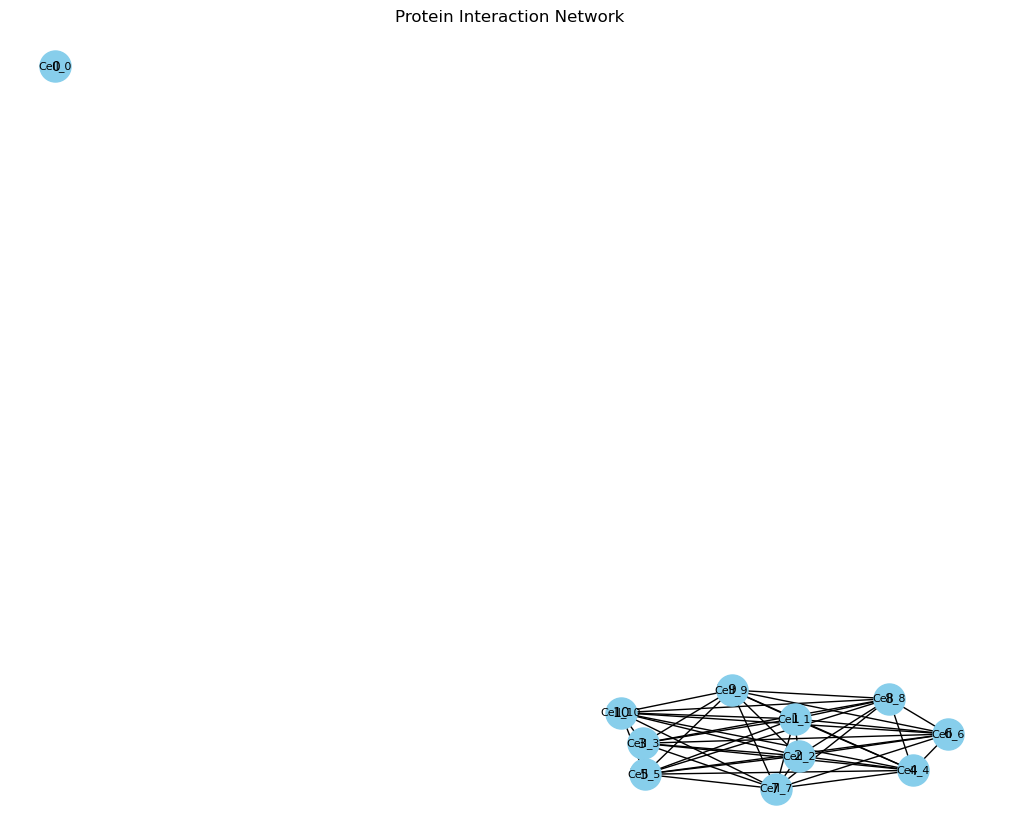

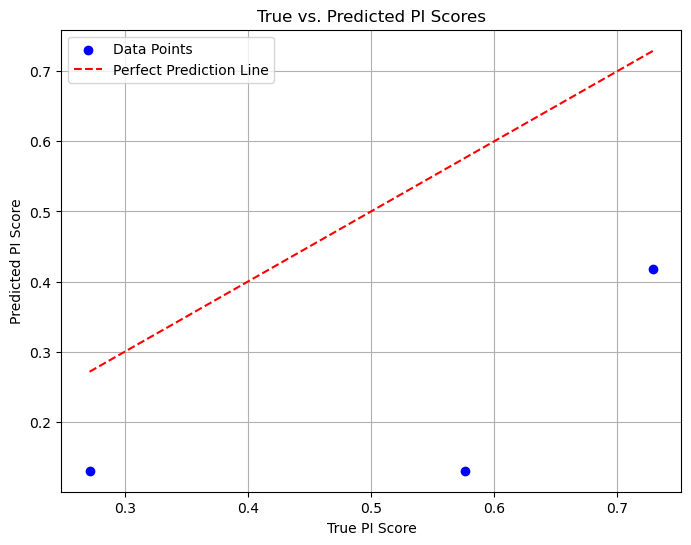

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load protein interaction network data
data = pd.read_csv('/users/barmanjy/Desktop/Persister Cell/GSE1000_series_matrix.txt', delimiter='\t', skiprows=67, header=None)

# Preprocess your data and construct a graph
# Example code for constructing a graph from your data (replace this with your actual data preprocessing)
def preprocess_data(data):
   # Convert non-numeric values to NaN
    data = data.apply(pd.to_numeric, errors='coerce')

    # Calculate correlation matrix
    correlation_matrix = data.corr()

    # Threshold correlations (optional)
    threshold = 0.5
    adjacency_matrix = np.where(abs(correlation_matrix) > threshold, 1, 0)
    return adjacency_matrix


adjacency_matrix = preprocess_data(data)
G = nx.from_numpy_array(adjacency_matrix)

# Custom Transformer to extract network features
class NetworkFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, G):
        features = []
        betweenness = nx.betweenness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G)
        for node in G.nodes():
            node_features = [
                G.degree(node),
                nx.clustering(G, node),
                betweenness[node],
                eigenvector[node]
            ]
            features.append(node_features)
        return np.array(features)

# Function to train deep learning model for feature extraction
def train_deep_learning_model(X_train, y_train, param_grid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = Sequential()
    model.add(LSTM(units=param_grid['units'], input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=param_grid['optimizer'], loss='mean_squared_error')

    X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    model.fit(X_train_reshaped, y_train, epochs=param_grid['epochs'], batch_size=param_grid['batch_size'])
    
    return model, scaler

# Placeholder for function to calculate PI scores
def calculate_pi(G, d, X_network, model, scaler):
    # Placeholder implementation for PI calculation
    # Replace with actual implementation based on your requirements
    pi_scores = np.random.rand(len(G.nodes()))
    return pi_scores

# Placeholder for function to calculate distances based on edge weights
def calculate_distances(G, a, x):
    distances = {}
    for edge in G.edges():
        i, j = edge
        distances[edge] = a[i][j] * x[i] * x[j]
    return distances

# Placeholder for function to calculate Ricci curvature
def calculate_ricci_curvature(G, a, x):
    # Placeholder implementation for Ricci curvature calculation
    # Replace with actual implementation based on your requirements
    ricci_curvature = np.random.rand(len(G.nodes()))
    return ricci_curvature

# Placeholder for function to update distances in discrete Ricci flow
def update_distances(G, d, ricci_curvature, delta_t):
    # Placeholder implementation for distance update
    # Replace with actual implementation based on your requirements
    updated_distances = {edge: distance + ricci_curvature[edge[0]] * delta_t for edge, distance in d.items()}
    return updated_distances

# Function to perform discrete Ricci flow iterations
def discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations, convergence_threshold=1e-6):
    d_stem = calculate_distances(G, a, x_stem)
    d_diff = calculate_distances(G, a, x_diff)
    ricci_curvature_stem = calculate_ricci_curvature(G, a, x_stem)
    ricci_curvature_diff = calculate_ricci_curvature(G, a, x_diff)
    prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    for _ in range(num_iterations):
        d_stem = update_distances(G, d_stem, ricci_curvature_stem, delta_t)
        d_diff = update_distances(G, d_diff, ricci_curvature_diff, delta_t)
        # Convergence check
        if np.allclose(np.array(list(d_stem.values())), np.array(list(prev_d_stem.values())), atol=convergence_threshold) and \
           np.allclose(np.array(list(d_diff.values())), np.array(list(prev_d_diff.values())), atol=convergence_threshold):
            break
        prev_d_stem, prev_d_diff = d_stem.copy(), d_diff.copy()
    return d_stem, d_diff

# Placeholder data for training and testing
target_variable = np.random.rand(11)  # Placeholder for target variable

# Define hyperparameters for the deep learning model
param_grid = {
    'units': 50,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}

print("Shape of adjacency matrix:", adjacency_matrix.shape)
print("Shape of target variable:", target_variable.shape)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(adjacency_matrix, target_variable, test_size=0.2, random_state=42)

# Train deep learning model for feature extraction
model, scaler = train_deep_learning_model(X_train, y_train, param_grid)

# Extract network features
network_feature_extractor = NetworkFeatureExtractor()
X_network = network_feature_extractor.transform(G)

# Placeholder for edge weights based on gene expression data
# Replace this with actual edge weights based on gene expression data or other network-based weight calculations
a = np.random.rand(len(G.nodes()), len(G.nodes()))

# Define initial and final states for the Ricci flow
# You can replace these placeholders with actual initial and final states based on biological knowledge
x_stem = np.random.rand(len(G.nodes()))  # Placeholder for undifferentiated cell state
x_diff = np.random.rand(len(G.nodes()))  # Placeholder for fully differentiated cell state

# Perform discrete Ricci flow iterations
delta_t = 0.1  # Placeholder for time step
num_iterations = 10  # Placeholder for number of iterations
d_stem, d_diff = discrete_ricci_flow(G, a, x_stem, x_diff, delta_t, num_iterations)

# Calculate proliferation index
pi_scores_stem = calculate_pi(G, d_stem, X_network, model, scaler)
pi_scores_diff = calculate_pi(G, d_diff, X_network, model, scaler)

# Convert pi_scores_stem and pi_scores_diff to dictionaries for easier manipulation
pi_scores_stem = {node: score for node, score in enumerate(pi_scores_stem)}
pi_scores_diff = {node: score for node, score in enumerate(pi_scores_diff)}

# Categorize cells into groups based on proliferation index
threshold1 = 0.5
threshold2 = 0.3
threshold3 = 0.1

group1 = {node: score for node, score in pi_scores_stem.items() if score > threshold1}
group2 = {node: score for node, score in pi_scores_stem.items() if threshold2 < score <= threshold1}
group3 = {node: score for node, score in pi_scores_stem.items() if threshold3 < score <= threshold2}
group4 = {node: score for node, score in pi_scores_stem.items() if score <= threshold3}

# Print cell groups
print("\nCell Groups:")
print("Group 1 (Carcinogenic Persister Cell):", group1)
print("Group 2 (Probably Carcinogenic Persister Cell):", group2)
print("Group 3 (Possibly Carcinogenic Persister Cell):", group3)
print("Group 4 (Non-Carcinogenic Persister Cell):", group4)

# Model evaluation metrics
y_pred = model.predict(scaler.transform(X_test))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model evaluation metrics
print("\nModel Evaluation Metrics:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

# Visualization: Network structure
plt.figure(figsize=(10, 8))

# Draw the network
pos = nx.spring_layout(G)  # Compute layout for nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)

# Add labels for each node with its index and gene symbol
labels = {node: f"Cell_{node}" for node in G.nodes()}  # Assuming no gene symbols available
nx.draw_networkx_labels(G, pos, labels, font_color='black', font_size=8)

plt.title('Protein Interaction Network')
plt.show()

# Visualization: Scatter plot of PI scores vs. true scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True PI Score')
plt.ylabel('Predicted PI Score')
plt.title('True vs. Predicted PI Scores')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import numpy as np

# Load the gene expression data
data = pd.read_csv('/users/barmanjy/Desktop/Persister Cell/GSE1000_series_matrix.txt', delimiter='\t', skiprows=67, header=None)

# Convert non-numeric values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Calculate correlation matrix
correlation_matrix = data.corr()

# Threshold correlations (optional)
threshold = 1
adjacency_matrix = np.where(abs(correlation_matrix) > threshold, 1, 0)

# Print or use the adjacency matrix
print(adjacency_matrix)


[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [18]:
#26.05.2024